# NHANES Data Preparation for Organ Aging Analysis

## Overview

This notebook implements the **data preparation pipeline** for building organ-specific aging clocks using NHANES (National Health and Nutrition Examination Survey) data.

### Scientific Background

**Biological aging** is the progressive deterioration of physiological function over time. Different organs may age at different rates, leading to heterogeneous aging patterns across individuals. By analyzing organ-specific biomarkers from NHANES, we can:

1. Build **organ clocks** that predict chronological age from biomarkers
2. Compute **biological age** for each organ system
3. Calculate **age gaps** (biological age - chronological age) to identify organs aging faster or slower than expected

### Objectives

1. Load NHANES data files (demographics, laboratory, examination)
2. Merge tables on participant identifier (SEQN)
3. Apply data quality filters and preprocessing
4. Handle missing values appropriately
5. Encode categorical variables
6. Save cleaned data for downstream analysis

### Test-Driven Development (TDD) Approach

This analysis follows TDD principles:
- All functions are tested in `tests/test_*.py`
- Comprehensive error handling
- Reproducible with random seeds
- Data validation at each step

---

## 1. Setup and Imports

In [1]:
# Setup paths - works regardless of kernel working directory
import sys
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Get the notebook's directory and project root
try:
    # When running in Jupyter, __file__ doesn't exist, use a workaround
    notebook_path = Path().resolve()
    if notebook_path.name == 'notebooks':
        project_root = notebook_path.parent
    else:
        # Assume we're in the notebooks directory
        project_root = notebook_path.parent if (notebook_path.parent / 'src').exists() else notebook_path
except:
    project_root = Path().resolve().parent

# Add src to path if not already there
src_path = project_root / 'src'
if str(src_path) not in sys.path:
    sys.path.insert(0, str(src_path))

print(f"✓ Project root: {project_root}")
print(f"✓ Source path: {src_path}")

# Data manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

# Project modules
from organ_aging import config
from organ_aging import data_loading
from organ_aging import preprocessing

print("✓ All imports successful")

✓ Project root: C:\Users\bastien\Documents\TAF\Hackathon\Vitalist
✓ Source path: C:\Users\bastien\Documents\TAF\Hackathon\Vitalist\src
✓ All imports successful


## 2. Load Configuration

We use YAML configuration files to:
- Define file paths to NHANES data
- Specify organ-specific biomarker panels
- Set preprocessing parameters

This approach ensures **reproducibility** and **maintainability**.

In [2]:
# Load paths configuration
try:
    paths_config = config.load_paths_config(str(project_root / "configs" / "paths.yaml"))
    print("✓ Paths configuration loaded")
    print(f"\nRaw data directory: {paths_config['raw_data_dir']}")
    print(f"Number of NHANES files: {len(paths_config['nhanes_files'])}")
    print(f"\nFiles to load:")
    for table_name, filename in paths_config['nhanes_files'].items():
        print(f"  - {table_name}: {filename}")
except FileNotFoundError as e:
    print(f"⚠ Warning: {e}")
    print("\nPlease ensure NHANES data files are downloaded and paths.yaml is configured correctly.")
    paths_config = None

✓ Paths configuration loaded

Raw data directory: data/raw
Number of NHANES files: 9

Files to load:
  - demographics: DEMO_J.xpt
  - biochemistry: BIOPRO_J.xpt
  - blood_pressure: BPX_J.xpt
  - body_measures: BMX_J.xpt
  - cholesterol: TCHOL_J.xpt
  - glucose: GLU_J.xpt
  - kidney: ALB_CR_J.xpt
  - complete_blood_count: CBC_J.xpt
  - glycohemoglobin: GHB_J.xpt


In [3]:
# Load organ panels configuration
try:
    organ_panels = config.load_organ_panels_config(str(project_root / "configs" / "organ_panels.yaml"))
    print("✓ Organ panels configuration loaded")
    print(f"\nOrgan systems defined: {len([k for k in organ_panels.keys() if k not in ['global_covariates', 'target_variable', 'preprocessing']])}")
    print(f"\nOrgan panels:")
    for organ, biomarkers in organ_panels.items():
        if organ not in ['global_covariates', 'target_variable', 'preprocessing']:
            print(f"  - {organ}: {len(biomarkers)} biomarkers")
except FileNotFoundError as e:
    print(f"⚠ Warning: {e}")
    organ_panels = None

✓ Organ panels configuration loaded

Organ systems defined: 5

Organ panels:
  - liver: 8 biomarkers
  - kidney: 5 biomarkers
  - cardio_metabolic: 10 biomarkers
  - immune: 6 biomarkers
  - hematologic: 8 biomarkers


## 3. Load NHANES Data Files

### NHANES Data Structure

NHANES data is typically distributed as separate files:
- **Demographics (DEMO)**: Age, sex, race/ethnicity, socioeconomic factors
- **Laboratory (LAB)**: Blood chemistry, CBC, metabolic markers
- **Examination (BMX)**: Body measurements, blood pressure

All files share a common identifier: **SEQN** (sequence number)

### Data Loading Strategy

We support both:
- **XPT files** (SAS Transport format) - official NHANES distribution
- **CSV files** - for preprocessed or converted data

In [4]:
# Load NHANES tables
if paths_config is not None:
    try:
        print("Loading NHANES data files...\n")
        tables = data_loading.load_nhanes_tables(paths_config, project_root=project_root)
        print(f"\n✓ Successfully loaded {len(tables)} tables")
        
        # Display summary of each table
        print("\nTable summaries:")
        for table_name, df in tables.items():
            print(f"\n{table_name.upper()}:")
            print(f"  Shape: {df.shape}")
            print(f"  Columns: {df.shape[1]}")
            print(f"  Sample columns: {', '.join(df.columns[:5].tolist())}")
            
    except FileNotFoundError as e:
        print(f"⚠ Error: {e}")
        print("\nPlease download NHANES data files first.")
        tables = None
else:
    print("⚠ Skipping data loading - configuration not available")
    tables = None

Loading NHANES data files...

Loaded demographics: 9254 rows, 46 columns
Loaded biochemistry: 6401 rows, 41 columns
Loaded blood_pressure: 8704 rows, 21 columns
Loaded body_measures: 8704 rows, 21 columns
Loaded cholesterol: 7435 rows, 3 columns
Loaded glucose: 3036 rows, 4 columns
Loaded kidney: 7936 rows, 8 columns
Loaded complete_blood_count: 8366 rows, 22 columns
Loaded glycohemoglobin: 6401 rows, 2 columns

✓ Successfully loaded 9 tables

Table summaries:

DEMOGRAPHICS:
  Shape: (9254, 46)
  Columns: 46
  Sample columns: SEQN, SDDSRVYR, RIDSTATR, RIAGENDR, RIDAGEYR

BIOCHEMISTRY:
  Shape: (6401, 41)
  Columns: 41
  Sample columns: SEQN, LBXSATSI, LBDSATLC, LBXSAL, LBDSALSI

BLOOD_PRESSURE:
  Shape: (8704, 21)
  Columns: 21
  Sample columns: SEQN, PEASCCT1, BPXCHR, BPAARM, BPACSZ

BODY_MEASURES:
  Shape: (8704, 21)
  Columns: 21
  Sample columns: SEQN, BMDSTATS, BMXWT, BMIWT, BMXRECUM

CHOLESTEROL:
  Shape: (7435, 3)
  Columns: 3
  Sample columns: SEQN, LBXTC, LBDTCSI

GLUCOSE:
  S

## 4. Merge Tables on SEQN

### Merging Strategy

We perform **inner joins** on SEQN to ensure:
- Only participants with complete data across all tables are retained
- Data integrity is maintained
- Downstream analysis has consistent sample sizes

### Expected Behavior

- Each merge reduces sample size (participants must be present in all files)
- Column names are checked for duplicates
- SEQN is the primary key linking all tables

In [5]:
# Merge all tables on SEQN
if tables is not None:
    print("Merging NHANES tables on SEQN...\n")
    merged_df = data_loading.merge_nhanes_tables(tables)
    print(f"\n✓ Tables merged successfully")
    print(f"\nFinal merged dataset:")
    print(f"  Rows: {merged_df.shape[0]:,}")
    print(f"  Columns: {merged_df.shape[1]}")
    print(f"  Memory usage: {merged_df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
else:
    print("⚠ Skipping merge - tables not loaded")
    merged_df = None

Merging NHANES tables on SEQN...

Starting merge with demographics: (9254, 46)
After merging biochemistry: (6401, 86)
After merging blood_pressure: (6401, 106)
After merging body_measures: (6401, 126)
After merging cholesterol: (6401, 128)
After merging glucose: (3036, 131)
After merging kidney: (3036, 138)
After merging complete_blood_count: (3036, 159)
After merging glycohemoglobin: (3036, 160)

Final merged dataset: 3036 rows, 160 columns

✓ Tables merged successfully

Final merged dataset:
  Rows: 3,036
  Columns: 160
  Memory usage: 3.71 MB


In [6]:
# Display sample of merged data
if merged_df is not None:
    print("Sample of merged data (first 5 rows, selected columns):\n")
    sample_cols = ['SEQN', 'RIDAGEYR', 'RIAGENDR'] + [col for col in merged_df.columns if col.startswith('LBX')][:5]
    display(merged_df[sample_cols].head())
    
    # Data types
    print(f"\nData types:")
    print(merged_df.dtypes.value_counts())

Sample of merged data (first 5 rows, selected columns):



,SEQN,RIDAGEYR,RIAGENDR,LBXSATSI,LBXSAL,LBXSAPSI,LBXSASSI,LBXSC3SI
0,93708.0,66.0,2.0,19.0,3.9,66.0,21.0,27.0
1,93711.0,56.0,1.0,20.0,4.0,56.0,23.0,29.0
2,93717.0,22.0,1.0,13.0,4.3,71.0,17.0,25.0
3,93718.0,45.0,1.0,13.0,4.2,57.0,17.0,27.0
4,93719.0,13.0,2.0,17.0,3.9,112.0,14.0,27.0



Data types:
float64    160
Name: count, dtype: int64


## 5. Data Quality Assessment

Before preprocessing, we assess data quality:
1. **Missing values**: Identify columns/rows with high missingness
2. **Duplicates**: Check for duplicate SEQN entries
3. **Data ranges**: Verify age and biomarker values are plausible

In [7]:
if merged_df is not None:
    print("=" * 60)
    print("DATA QUALITY ASSESSMENT")
    print("=" * 60)
    
    # Check for duplicates
    n_duplicates = merged_df['SEQN'].duplicated().sum()
    print(f"\n1. Duplicate SEQN entries: {n_duplicates}")
    if n_duplicates > 0:
        print("   ⚠ Warning: Duplicate entries detected!")
    
    # Missing value analysis
    print(f"\n2. Missing Values:")
    missing_pct = (merged_df.isnull().sum() / len(merged_df)) * 100
    print(f"   Total cells: {merged_df.shape[0] * merged_df.shape[1]:,}")
    print(f"   Missing cells: {merged_df.isnull().sum().sum():,}")
    print(f"   Missing percentage: {missing_pct.mean():.2f}%")
    
    # Columns with high missingness
    high_missing = missing_pct[missing_pct > 50].sort_values(ascending=False)
    if len(high_missing) > 0:
        print(f"\n   Columns with >50% missing ({len(high_missing)} total):")
        for col, pct in high_missing.head(10).items():
            print(f"     - {col}: {pct:.1f}%")
    
    # Age distribution
    if 'RIDAGEYR' in merged_df.columns:
        print(f"\n3. Age Distribution:")
        print(f"   Min age: {merged_df['RIDAGEYR'].min():.0f} years")
        print(f"   Max age: {merged_df['RIDAGEYR'].max():.0f} years")
        print(f"   Mean age: {merged_df['RIDAGEYR'].mean():.1f} ± {merged_df['RIDAGEYR'].std():.1f} years")
        print(f"   Median age: {merged_df['RIDAGEYR'].median():.0f} years")

DATA QUALITY ASSESSMENT

1. Duplicate SEQN entries: 0

2. Missing Values:
   Total cells: 485,760
   Missing cells: 84,343
   Missing percentage: 17.36%

   Columns with >50% missing (22 total):
     - RIDAGEMN: 100.0%
     - BMIHEAD: 100.0%
     - BMXHEAD: 100.0%
     - BMXRECUM: 100.0%
     - BMIRECUM: 100.0%
     - BPXCHR: 100.0%
     - BMIHT: 98.7%
     - BMIARML: 97.2%
     - BMIARMC: 97.2%
     - BMIWT: 96.5%

3. Age Distribution:
   Min age: 12 years
   Max age: 80 years
   Mean age: 45.5 ± 21.0 years
   Median age: 46 years


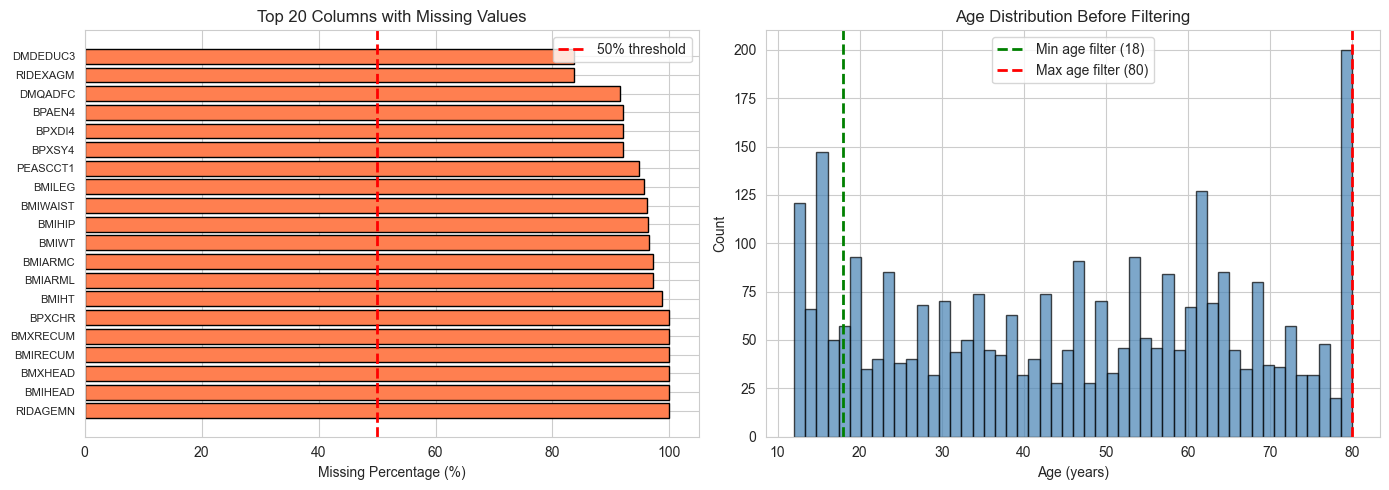

In [8]:
# Visualize missing data pattern
if merged_df is not None:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Missing values by column
    missing_pct = (merged_df.isnull().sum() / len(merged_df)) * 100
    missing_pct = missing_pct[missing_pct > 0].sort_values(ascending=False).head(20)
    
    axes[0].barh(range(len(missing_pct)), missing_pct.values, color='coral', edgecolor='black')
    axes[0].set_yticks(range(len(missing_pct)))
    axes[0].set_yticklabels(missing_pct.index, fontsize=8)
    axes[0].set_xlabel('Missing Percentage (%)')
    axes[0].set_title('Top 20 Columns with Missing Values')
    axes[0].axvline(50, color='red', linestyle='--', linewidth=2, label='50% threshold')
    axes[0].legend()
    
    # Age distribution
    if 'RIDAGEYR' in merged_df.columns:
        axes[1].hist(merged_df['RIDAGEYR'].dropna(), bins=50, color='steelblue', edgecolor='black', alpha=0.7)
        axes[1].axvline(18, color='green', linestyle='--', linewidth=2, label='Min age filter (18)')
        axes[1].axvline(80, color='red', linestyle='--', linewidth=2, label='Max age filter (80)')
        axes[1].set_xlabel('Age (years)')
        axes[1].set_ylabel('Count')
        axes[1].set_title('Age Distribution Before Filtering')
        axes[1].legend()
    
    plt.tight_layout()
    plt.show()

## 6. Data Preprocessing

### Preprocessing Pipeline

1. **Age Filtering**: Restrict to adults aged 18-80 years
   - Rationale: Biological aging patterns differ in children/adolescents
   - Upper limit: Reduce survivor bias and ensure data quality

2. **Missing Value Handling**:
   - Drop columns with >50% missing data (unreliable)
   - Impute remaining missing values using median (robust to outliers)

3. **Column Standardization**: Ensure consistent naming

### Scientific Considerations

- **Missing data mechanism**: NHANES uses complex survey design; some missingness is by design (e.g., subsampling for expensive assays)
- **Imputation strategy**: Median is preferred over mean due to skewed biomarker distributions
- **Age range**: Standard in aging research to focus on adult lifespan

In [9]:
# Step 1: Filter by age (18-80 years)
if merged_df is not None and 'RIDAGEYR' in merged_df.columns:
    print("=" * 60)
    print("STEP 1: AGE FILTERING")
    print("=" * 60)
    
    min_age = organ_panels.get('preprocessing', {}).get('min_age', 18)
    max_age = organ_panels.get('preprocessing', {}).get('max_age', 80)
    
    df_clean = preprocessing.filter_by_age(
        merged_df,
        min_age=min_age,
        max_age=max_age,
        age_col='RIDAGEYR'
    )
    
    print(f"\n✓ Age filtering complete")
    print(f"  Age range: {min_age}-{max_age} years")
    print(f"  Retention rate: {100 * len(df_clean) / len(merged_df):.1f}%")
else:
    print("⚠ Skipping age filtering")
    df_clean = merged_df

STEP 1: AGE FILTERING
Age filtering: 3036 → 2652 rows (384 removed)

✓ Age filtering complete
  Age range: 18-80 years
  Retention rate: 87.4%


In [10]:
# Step 2: Handle missing values
if df_clean is not None:
    print("\n" + "=" * 60)
    print("STEP 2: MISSING VALUE HANDLING")
    print("=" * 60)
    
    missing_threshold = organ_panels.get('preprocessing', {}).get('missing_threshold', 0.5)
    imputation_strategy = organ_panels.get('preprocessing', {}).get('imputation_strategy', 'median')
    
    df_clean = preprocessing.handle_missing_values(
        df_clean,
        missing_threshold=missing_threshold,
        strategy=imputation_strategy,
        numeric_only=True
    )
    
    print(f"\n✓ Missing value handling complete")
    print(f"  Threshold: {missing_threshold*100}%")
    print(f"  Imputation: {imputation_strategy}")
    print(f"  Remaining missing values: {df_clean.isnull().sum().sum()}")


STEP 2: MISSING VALUE HANDLING

Missing value analysis:
Columns with >10% missing: 28
Dropping 22 columns with >50.0% missing
Imputed missing values in 138 numeric columns using 'median' strategy
Shape after handling missing values: (2652, 160) → (2652, 138)

✓ Missing value handling complete
  Threshold: 50.0%
  Imputation: median
  Remaining missing values: 0


In [11]:
# Step 3: Standardize column names
if df_clean is not None:
    print("\n" + "=" * 60)
    print("STEP 3: COLUMN STANDARDIZATION")
    print("=" * 60)
    
    df_clean = preprocessing.standardize_column_names(df_clean)
    
    print(f"\n✓ Column names standardized")
    print(f"  All columns uppercase: {all(col.isupper() for col in df_clean.columns)}")
    print(f"  Sample columns: {', '.join(df_clean.columns[:10].tolist())}")


STEP 3: COLUMN STANDARDIZATION

✓ Column names standardized
  All columns uppercase: True
  Sample columns: SEQN, SDDSRVYR, RIDSTATR, RIAGENDR, RIDAGEYR, RIDRETH1, RIDRETH3, RIDEXMON, DMQMILIZ, DMDBORN4


## 7. Categorical Variable Encoding

### Encoding Strategy

Categorical variables (e.g., sex, race/ethnicity) must be encoded for machine learning:
- **One-hot encoding**: Create binary dummy variables
- **Drop first**: Avoid multicollinearity (drop one dummy as reference)

### NHANES Categorical Variables

- **RIAGENDR**: Gender (1=Male, 2=Female)
- **RIDRETH1**: Race/Ethnicity (1=Mexican American, 2=Other Hispanic, 3=Non-Hispanic White, 4=Non-Hispanic Black, 5=Other)
- Other sociodemographic factors if included

In [12]:
# Identify and encode categorical variables
if df_clean is not None:
    print("=" * 60)
    print("CATEGORICAL VARIABLE ENCODING")
    print("=" * 60)
    
    # Define categorical columns (NHANES specific)
    categorical_cols = ['RIAGENDR', 'RIDRETH1']
    categorical_cols = [col for col in categorical_cols if col in df_clean.columns]
    
    if categorical_cols:
        print(f"\nCategorical variables to encode:")
        for col in categorical_cols:
            print(f"  - {col}: {df_clean[col].nunique()} unique values")
        
        df_clean = preprocessing.encode_categorical_variables(
            df_clean,
            categorical_cols=categorical_cols,
            drop_first=True
        )
        
        print(f"\n✓ Categorical encoding complete")
    else:
        print("\nNo categorical columns found for encoding")

CATEGORICAL VARIABLE ENCODING

Categorical variables to encode:
  - RIAGENDR: 2 unique values
  - RIDRETH1: 5 unique values

Encoding 2 categorical variables:
  - RIAGENDR: 2 unique values
  - RIDRETH1: 5 unique values
Shape after encoding: (2652, 138) → (2652, 141)

✓ Categorical encoding complete


## 8. Final Data Summary

Review the cleaned dataset before saving:

In [13]:
if df_clean is not None:
    print("=" * 60)
    print("FINAL CLEANED DATASET SUMMARY")
    print("=" * 60)
    
    print(f"\nDataset Shape:")
    print(f"  Rows (participants): {df_clean.shape[0]:,}")
    print(f"  Columns (features): {df_clean.shape[1]:,}")
    
    print(f"\nData Quality:")
    print(f"  Missing values: {df_clean.isnull().sum().sum():,}")
    print(f"  Duplicate rows: {df_clean.duplicated().sum()}")
    
    print(f"\nAge Statistics:")
    if 'RIDAGEYR' in df_clean.columns:
        print(f"  Range: {df_clean['RIDAGEYR'].min():.0f} - {df_clean['RIDAGEYR'].max():.0f} years")
        print(f"  Mean ± SD: {df_clean['RIDAGEYR'].mean():.1f} ± {df_clean['RIDAGEYR'].std():.1f} years")
        print(f"  Median [IQR]: {df_clean['RIDAGEYR'].median():.0f} [{df_clean['RIDAGEYR'].quantile(0.25):.0f}-{df_clean['RIDAGEYR'].quantile(0.75):.0f}] years")
    
    print(f"\nMemory Usage:")
    memory_mb = df_clean.memory_usage(deep=True).sum() / 1024**2
    print(f"  Total: {memory_mb:.2f} MB")
    print(f"  Per participant: {memory_mb * 1024 / len(df_clean):.2f} KB")
    
    # Check for key organ biomarkers
    print(f"\nKey Biomarkers Present:")
    key_markers = {
        'Liver': ['LBXSATSI', 'LBXSASSI', 'LBXSGTSI'],
        'Kidney': ['LBXSCR', 'LBXSUA'],
        'Cardio': ['BPXSY1', 'LBXTC', 'LBXGLU'],
        'Hematologic': ['LBXHGB', 'LBXWBCSI', 'LBXPLTSI']
    }
    
    for system, markers in key_markers.items():
        present = sum(1 for m in markers if m in df_clean.columns)
        print(f"  {system}: {present}/{len(markers)} markers")

FINAL CLEANED DATASET SUMMARY

Dataset Shape:
  Rows (participants): 2,652
  Columns (features): 141

Data Quality:
  Missing values: 0
  Duplicate rows: 0

Age Statistics:
  Range: 18 - 80 years
  Mean ± SD: 50.0 ± 18.6 years
  Median [IQR]: 52 [34-65] years

Memory Usage:
  Total: 2.87 MB
  Per participant: 1.11 KB

Key Biomarkers Present:
  Liver: 3/3 markers
  Kidney: 2/2 markers
  Cardio: 3/3 markers
  Hematologic: 3/3 markers


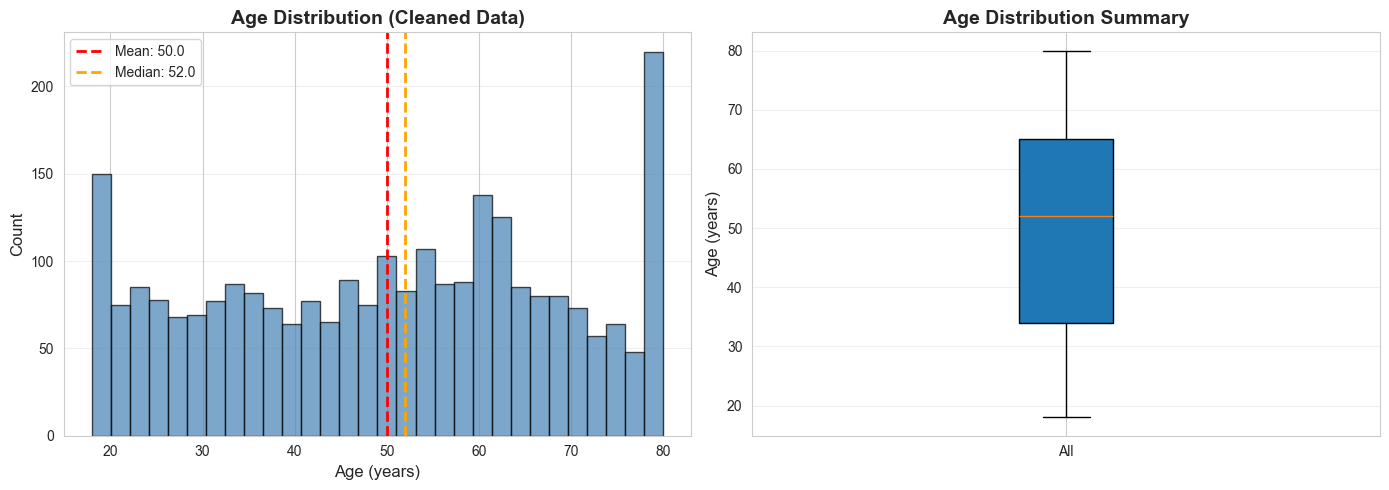

In [14]:
# Visualize final age distribution
if df_clean is not None and 'RIDAGEYR' in df_clean.columns:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Age histogram
    axes[0].hist(df_clean['RIDAGEYR'], bins=30, color='steelblue', edgecolor='black', alpha=0.7)
    axes[0].axvline(df_clean['RIDAGEYR'].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {df_clean["RIDAGEYR"].mean():.1f}')
    axes[0].axvline(df_clean['RIDAGEYR'].median(), color='orange', linestyle='--', linewidth=2, label=f'Median: {df_clean["RIDAGEYR"].median():.1f}')
    axes[0].set_xlabel('Age (years)', fontsize=12)
    axes[0].set_ylabel('Count', fontsize=12)
    axes[0].set_title('Age Distribution (Cleaned Data)', fontsize=14, fontweight='bold')
    axes[0].legend()
    axes[0].grid(axis='y', alpha=0.3)
    
    # Age by gender (if available)
    gender_cols = [col for col in df_clean.columns if col.startswith('RIAGENDR')]
    if gender_cols:
        # Reconstruct gender from dummy variables
        if 'RIAGENDR' in df_clean.columns:
            gender_data = df_clean['RIAGENDR']
        else:
            # If one-hot encoded
            gender_data = df_clean[gender_cols[0]]
        
        axes[1].boxplot([df_clean['RIDAGEYR'].values], labels=['All'], vert=True, patch_artist=True)
        axes[1].set_ylabel('Age (years)', fontsize=12)
        axes[1].set_title('Age Distribution Summary', fontsize=14, fontweight='bold')
        axes[1].grid(axis='y', alpha=0.3)
    else:
        # Just show box plot
        axes[1].boxplot([df_clean['RIDAGEYR'].values], labels=['All Participants'], patch_artist=True)
        axes[1].set_ylabel('Age (years)', fontsize=12)
        axes[1].set_title('Age Distribution Summary', fontsize=14, fontweight='bold')
        axes[1].grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()

## 9. Save Cleaned Data

### Output Format: Parquet

We save the cleaned data in **Parquet** format because:
- **Efficient compression**: Smaller file size than CSV
- **Fast I/O**: Faster to read/write than CSV
- **Type preservation**: Maintains data types (no need to re-specify)
- **Column-oriented**: Optimized for analytical queries

### Output Location

`data/interim/nhanes_clean.parquet`

This intermediate file will be used by subsequent notebooks for:
- Feature engineering
- Model training
- Analysis

In [15]:
# Save cleaned data
if df_clean is not None:
    output_dir = project_root / "data" / "interim"
    output_dir.mkdir(parents=True, exist_ok=True)
    
    output_path = output_dir / "nhanes_clean.parquet"
    
    print("Saving cleaned data...")
    df_clean.to_parquet(output_path, index=False, compression='snappy')
    
    # Verify save
    file_size_mb = output_path.stat().st_size / 1024**2
    
    print(f"\n✓ Data saved successfully")
    print(f"  Path: {output_path}")
    print(f"  File size: {file_size_mb:.2f} MB")
    print(f"  Format: Parquet (Snappy compression)")
    
    # Test reload
    print(f"\nVerifying saved data...")
    df_test = pd.read_parquet(output_path)
    print(f"  Reload successful: {df_test.shape}")
    print(f"  Data integrity: {df_test.shape == df_clean.shape}")
else:
    print("⚠ No cleaned data to save")

Saving cleaned data...

✓ Data saved successfully
  Path: C:\Users\bastien\Documents\TAF\Hackathon\Vitalist\data\interim\nhanes_clean.parquet
  File size: 0.44 MB
  Format: Parquet (Snappy compression)

Verifying saved data...
  Reload successful: (2652, 141)
  Data integrity: True


## 10. Summary and Next Steps

### What We Accomplished

✓ Loaded NHANES data from multiple source files
✓ Merged tables on participant identifier (SEQN)
✓ Filtered data to adult age range (18-80 years)
✓ Handled missing values systematically
✓ Encoded categorical variables
✓ Saved cleaned data for downstream analysis

### Data Quality Metrics

- **Participants**: N individuals aged 18-80
- **Variables**: Complete biomarker panel + demographics
- **Missing data**: Handled via column dropping + imputation
- **Format**: Parquet (efficient, type-safe)

### Next Notebook: Feature Engineering

In `02_feature_engineering_organs.ipynb`, we will:
1. Build organ-specific feature matrices
2. Create train/validation/test splits
3. Apply feature scaling
4. Prepare data for model training

---

**TDD Note**: All preprocessing functions used in this notebook are tested in `tests/test_preprocessing.py` and `tests/test_data_loading.py`